In [1]:
from scipy.io import loadmat
import torch
from matplotlib import pyplot as plt
from vae import VanillaVAE
from losses import loss_function, BetaSchedulerCyclic, BetaSchedulerMono
import torchvision
from tqdm import tqdm
import os
import time
from torchvision.utils import save_image
from itertools import islice
from blocks import *

In [2]:
kwargs = {
    'HAS_BN': True,
    'SReLU': False,
    'HAS_ST': False,
    'DROPOUT': 0,
    'CIFAR': True
}
# a = ResStem(w_in=3, w_out=64, **kwargs)
# print (kwargs['HAS_BN'])
a = ResStage(w_in=64, w_out=64, stride=2, d=1, **kwargs)
print (a)
# for m in a.modules():
#     if m i

ResStage(
  (b1): ResBlock(
    (f): BasicTransform(
      (a): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (a_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a_relu): ReLU(inplace=True)
      (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
  )
)


In [3]:
kwargs = {
    'HAS_BN': True,
    'SReLU': False,
    'HAS_ST': False,
    'DROPOUT': 0,
    'CIFAR': True
}
z_size = 20
in_channels = 1
vae = VanillaVAE(in_channels=in_channels, latent_dim=z_size, res=32, stage_count=3, layer_mult=64, d=1, **kwargs)
vae.cuda()
vae.train()

[64, 128, 256]
[1, 1, 1]
0
1
2


VanillaVAE(
  (encoder): Sequential(
    (0): ResStem(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResStage(
      (b1): ResBlock(
        (f): BasicTransform(
          (a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (a_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (a_relu): ReLU(inplace=True)
          (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
    )
    (2): ResStage(
      (b1): ResBlock(
        (f): BasicTransform(
          (a): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
         

In [4]:
slen = 32

batch_size_train = 64
batch_size_test = 256
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [26]:
len(train_loader)

938

In [5]:
examples = list(test_loader)
print (examples[0][0].shape)
print (examples[0][1].shape)
print (examples[0][0][0].shape)

# plt.imshow (examples[0][0][0].view(slen,slen))
# plt.colorbar()
# plt.show()
# print (torch.mean(examples[0][0][0]))

torch.Size([256, 1, 32, 32])
torch.Size([256])
torch.Size([1, 32, 32])


In [6]:
results = vae.encoder(examples[0][0][0].view(1,1,slen,slen).cuda())
results[0].shape

torch.Size([256, 8, 8])

In [7]:
results = vae(examples[0][0][0].view(1,1,slen,slen).cuda())
results[0].shape

torch.Size([1, 1, 32, 32])

In [8]:
sample1 = torch.randn(64, z_size).view(-1, z_size).cuda()

In [9]:
a = vae.decoder_input(sample1)
print (a.shape)
a = a.view(sample1.shape[0], vae.last_hdim, vae.code_len, vae.code_len)
print (a.shape)

torch.Size([64, 16384])
torch.Size([64, 256, 8, 8])


In [10]:
a = vae.decoder(a)
print (a.shape)

torch.Size([64, 1, 32, 32])


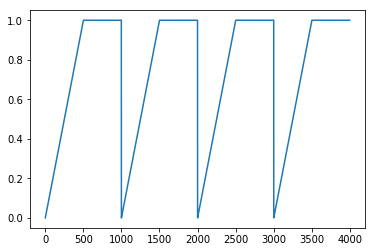

In [11]:
a = BetaSchedulerCyclic()

x = list(islice(a, 0, 4000))
plt.plot(x)
plt.show()

In [12]:
name='test_mnist_'+time.strftime("%m-%d-%Y_%H-%M-%S")
os.makedirs(name, exist_ok=True)
recon_dir = os.path.join (name,'results_recon')
os.makedirs(recon_dir, exist_ok=True)
gen_dir = os.path.join (name,'results_gen')
os.makedirs(gen_dir, exist_ok=True)

lr = 0.0005
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
train_epoch = 50

re_loss_arr = []
kl_loss_arr = []

# for decode testing, batch size of 64
sample1 = torch.randn(64, z_size).view(-1, z_size).cuda()
beta_iter = BetaSchedulerCyclic(stop=.01, period=len(train_loader))

for epoch in tqdm(range(train_epoch)):
    
    re_loss = 0
    kl_loss = 0
    
    for x in train_loader:
        x = x[0].cuda()
        vae.zero_grad()
#         print (x.shape)
        recon, mu, logvar = vae(x)
#         print (recon.shape)
        loss = loss_function(recon, x, mu, logvar, kld_weight=next(beta_iter))
        loss_re, loss_kl = loss['reconstruction_loss'], loss['KLD']
        (loss_re + loss_kl).backward()
        vae_optimizer.step()
        re_loss += loss_re.item()
        kl_loss += loss_kl.item()

    re_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    print('\n[%d/%d] recon loss: %.9f, KL loss: %.9f' % (
        (epoch + 1), train_epoch, re_loss, kl_loss))
    re_loss_arr.append(re_loss)
    kl_loss_arr.append(kl_loss)
    if epoch % 2 == 0:
        with torch.no_grad():
            vae.eval()
            x_rec, _, _ = vae(x)
            resultsample = torch.cat([x, x_rec]) * 0.3081 + 0.1307
            resultsample = resultsample.cpu()
            save_image(resultsample.view(-1, in_channels, slen*2, slen),
                       recon_dir + '/' + str(epoch) + '.png')
            x_rec = vae.decode(sample1)
            resultsample = x_rec * 0.3081 + 0.1307
            resultsample = resultsample.cpu()
            save_image(resultsample.view(-1, in_channels, slen, slen),
                       gen_dir + '/' + str(epoch) + '.png')
        vae.train()
        
    # checkpoint
    torch.save(vae.state_dict(), name + "/VAEmodel.pkl")
    
print("Training finish!... save training results")
torch.save(vae.state_dict(), "VAEmodel.pkl")
        

  0%|          | 0/50 [00:00<?, ?it/s]


[1/50] recon loss: 0.303319303, KL loss: 0.113512191


  4%|▍         | 2/50 [01:03<25:23, 31.74s/it]


[2/50] recon loss: 0.167832762, KL loss: 0.112400841


  6%|▌         | 3/50 [01:34<24:48, 31.68s/it]


[3/50] recon loss: 0.205156571, KL loss: 19627.912781353


  8%|▊         | 4/50 [02:06<24:15, 31.64s/it]


[4/50] recon loss: 0.271364420, KL loss: 0.532889591

[5/50] recon loss: 0.226147921, KL loss: 0.324426737


 12%|█▏        | 6/50 [03:10<23:15, 31.72s/it]


[6/50] recon loss: 0.213059645, KL loss: 0.244243023


 14%|█▍        | 7/50 [03:41<22:43, 31.71s/it]


[7/50] recon loss: 0.205680770, KL loss: 0.212730868


 16%|█▌        | 8/50 [04:13<22:11, 31.71s/it]


[8/50] recon loss: 0.201206571, KL loss: 0.186467460


 18%|█▊        | 9/50 [04:45<21:39, 31.69s/it]


[9/50] recon loss: 0.197376309, KL loss: 0.169682238


 20%|██        | 10/50 [05:16<21:10, 31.76s/it]


[10/50] recon loss: 0.195728454, KL loss: 0.163166821


 22%|██▏       | 11/50 [05:48<20:40, 31.80s/it]


[11/50] recon loss: 0.194209391, KL loss: 0.160701690


 24%|██▍       | 12/50 [06:20<20:06, 31.76s/it]


[12/50] recon loss: 0.192696947, KL loss: 0.160741855

[13/50] recon loss: 0.191801129, KL loss: 0.159112572


 28%|██▊       | 14/50 [07:24<19:08, 31.89s/it]


[14/50] recon loss: 0.190945867, KL loss: 0.168295000

[15/50] recon loss: 0.189672590, KL loss: 0.160256548


 32%|███▏      | 16/50 [08:28<18:03, 31.87s/it]


[16/50] recon loss: 0.187499240, KL loss: 0.163109295

[17/50] recon loss: 0.181704197, KL loss: 0.149120485


 36%|███▌      | 18/50 [09:31<16:58, 31.82s/it]


[18/50] recon loss: 0.181230510, KL loss: 0.154503369

[19/50] recon loss: 0.179857268, KL loss: 0.151327310


 40%|████      | 20/50 [10:35<15:53, 31.79s/it]


[20/50] recon loss: 0.179171268, KL loss: 0.148717787


 42%|████▏     | 21/50 [11:07<15:22, 31.80s/it]


[21/50] recon loss: 0.177739492, KL loss: 0.155289581


 44%|████▍     | 22/50 [11:38<14:50, 31.80s/it]


[22/50] recon loss: 0.177188495, KL loss: 0.148518463

[23/50] recon loss: 0.176072066, KL loss: 0.144542460


 48%|████▊     | 24/50 [12:42<13:46, 31.78s/it]


[24/50] recon loss: 0.174180042, KL loss: 0.145700320

[25/50] recon loss: 0.174185143, KL loss: 0.144136485


 52%|█████▏    | 26/50 [13:45<12:41, 31.74s/it]


[26/50] recon loss: 0.173596616, KL loss: 0.146402584

[27/50] recon loss: 0.173179560, KL loss: 0.150206792


 56%|█████▌    | 28/50 [14:49<11:37, 31.73s/it]


[28/50] recon loss: 0.172123729, KL loss: 0.150797754

[29/50] recon loss: 0.170583457, KL loss: 0.144851857


 60%|██████    | 30/50 [15:53<10:36, 31.81s/it]


[30/50] recon loss: 0.169347408, KL loss: 0.143540641


 60%|██████    | 30/50 [16:12<10:48, 32.41s/it]


KeyboardInterrupt: 

In [21]:
kl_loss_arr[2] = 0

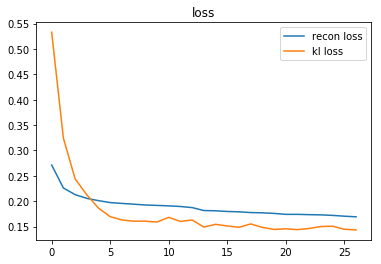

In [25]:
plt.plot(re_loss_arr[3:], label='recon loss')
plt.plot(kl_loss_arr[3:], label='kl loss')
plt.title('loss')
plt.legend()
plt.show()

# kl loss with mean, constant kl_weight = .1


[1/50] recon loss: 0.325829175, KL loss: 0.057964935

[2/50] recon loss: 0.296284202, KL loss: 0.048939405

[3/50] recon loss: 0.292565582, KL loss: 0.046701496

[4/50] recon loss: 0.290728960, KL loss: 0.045412801


# kl loss with sum, constant kl_weight = .1


[1/50] recon loss: 0.606855381, KL loss: 0.090462280

[2/50] recon loss: 0.593248408, KL loss: 0.017188402

[3/50] recon loss: 0.591825014, KL loss: 0.010229738

[4/50] recon loss: 0.591900916, KL loss: 0.007903290

[5/50] recon loss: 0.591713661, KL loss: 0.006736573


# ISOnet

In [ ]:
from ISONet.isonet.models import *